<a href="https://colab.research.google.com/github/NavyaRocky02/NavyaRocky02/blob/main/edunetproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload an empty room image:


Saving download (3).jpeg to download (3) (1).jpeg


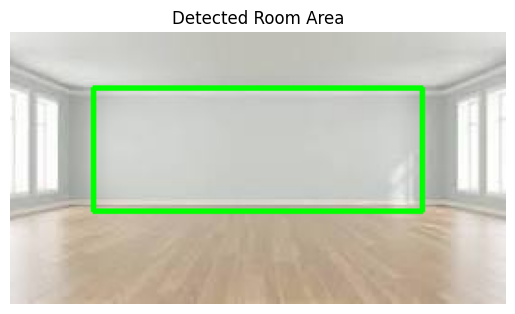

Upload images for Chair, Bed, and Sofa:


Saving bed.jpeg to bed (1).jpeg
Saving sofa.jpeg to sofa (1).jpeg
Image for Chair not found. Skipping...
Image for frame not found. Skipping...
Image for dressing table not found. Skipping...
Sofa does not fit in the room.
Objects placed in the room:
Bed: 1


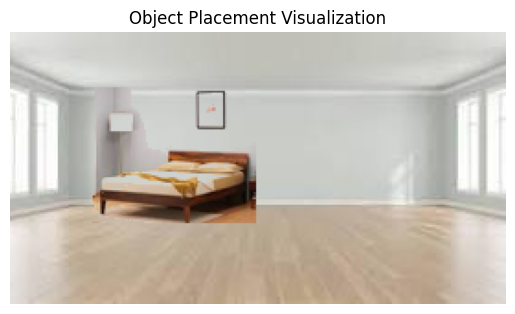

In [2]:
# Import necessary libraries
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

# Function to upload images
def upload_images():
    uploaded = files.upload()
    return {name.lower(): Image.open(name) for name in uploaded.keys()}

# Function to add alpha channel if needed
def add_alpha_channel(image):
    if image.mode != 'RGBA':
        image = image.convert('RGBA')
    return image

# Function to create transparency mask for JPEG images
def create_mask(image):
    # Convert to grayscale to find white areas
    gray = image.convert('L')
    # Create a binary mask: white (255) becomes transparent (0), other colors opaque (255)
    mask = gray.point(lambda x: 0 if x > 200 else 255, mode='1')
    return mask

# Function to overlay object images on room image
def overlay_image(bg, fg, x, y, scale=1.0):
    # Resize the object image with LANCZOS resampling for better quality
    fg_resized = fg.resize((int(fg.width * scale), int(fg.height * scale)), Image.LANCZOS)
    # Create mask for JPEG images
    mask = create_mask(fg_resized)
    # Paste the object image onto the background with the created mask
    bg.paste(fg_resized, (x, y), mask)

# Step 1: Upload Room Image
print("Upload an empty room image:")
room_image_file = files.upload()
room_image = Image.open(next(iter(room_image_file.keys())))
room_image_np = np.array(room_image)
room_image_cv = cv2.cvtColor(room_image_np, cv2.COLOR_RGB2BGR)

# Step 2: Room Detection (Simplified using color thresholding)
gray = cv2.cvtColor(room_image_cv, cv2.COLOR_BGR2GRAY)
_, thresholded = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assume the largest contour is the room area
room_area = 0
x, y, w, h = 0, 0, 0, 0
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    room_area = w * h
    cv2.rectangle(room_image_cv, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display detected room area
plt.imshow(cv2.cvtColor(room_image_cv, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Room Area')
plt.show()

# Step 3: Upload Object Images
print("Upload images for Chair, Bed, and Sofa:")
object_images = upload_images()

# Function to get image by checking keywords in filenames
def get_image(keyword):
    for filename, img in object_images.items():
        if keyword in filename:
            return img
    return None

# Proceed only if room area is detected
if room_area > 0:
    # Define objects and their dimensions (example in pixels)
    objects = {
        "Chair": {"size": (50, 50), "image": get_image("chair")},
        "frame": {"size": (100, 60), "image": get_image("frame")},
        "dressing table": {"size": (100, 60), "image": get_image("dressing table")},
        "Bed": {"size": (100, 60), "image": get_image("bed")},
        "Sofa": {"size": (120, 70), "image": get_image("sofa")}
    }

    # Convert OpenCV image to PIL for easy overlay
    output_image = room_image.copy()

    # Track objects placed
    placed_objects = {}
    padding = 20  # Space between objects
    current_x, current_y = x, y

    for obj_name, details in objects.items():
        if details["image"] is None:
            print(f"Image for {obj_name} not found. Skipping...")
            continue

        obj_img = add_alpha_channel(details["image"])

        obj_w, obj_h = details["size"]

        # Check if the object fits in the current position
        if (current_x + obj_w < x + w) and (current_y + obj_h < y + h):
            # Overlay the image
            overlay_image(output_image, obj_img, current_x, current_y, scale=0.5)
            placed_objects[obj_name] = 1
            # Update position for next object
            current_x += obj_w + padding
        else:
            print(f"{obj_name} does not fit in the room.")

    # Display the objects that have been placed
    print("Objects placed in the room:")
    for obj, count in placed_objects.items():
        print(f"{obj}: {count}")

    # Display the visualization
    plt.imshow(output_image)
    plt.axis('off')
    plt.title('Object Placement Visualization')
    plt.show()
else:
    print("Skipping object fitting as no room area was detected.")